In [38]:
import numpy as np
import pandas as pd
import json
import sys
import os
# Use os.getcwd() to get current working directory and navigate to project root
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from lod.voxelization.voxel_methods import AggregationMethod

import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
data_dir = "/main/rajrup/Dropbox/Project/GsplatStream/gsplat/results"
initial_iter = 1
frame_id = 0
actor = "Actor01"
sequence = "Sequence1"
resolution = 4
best_psnr = 35.89 # Later read from stats.json file

allowable_voxel_sizes = [0.001, 0.0025, 0.005, 0.01]
exp_names = [
    f"actorshq_l1_0.5_ssim_0.5_alpha_1.0_to_voxel_size_{voxel_size}"
    for voxel_size in allowable_voxel_sizes
]

aggregate_methods = [
    AggregationMethod.sum,  # Sum of gaussians
    AggregationMethod.dominant,  # Dominant gaussian
    AggregationMethod.mean,  # Mean of gaussians
    AggregationMethod.kl_moment,  # KL(p||q) first‑/second‑moment match
    AggregationMethod.h3dgs,  # H3DGS aggregation method
    AggregationMethod.kl_moment_hybrid_mean_moment,  # KL(p||q) for 1st moment
    AggregationMethod.h3dgs_hybrid_mean_moment,  # H3DGS for 1st moment
    # AggregationMethod.w2,  # Wasserstein-2 distance aggregation method
    # AggregationMethod.w2_h3dgs,
    # AggregationMethod.scales_voxel_width,  # Scales equal to voxel size
]

aggregate_methods_rename = [
    "Weighted Sum",
    "Dominant (Mode Seeking)",
    "Mean",
    "KL (Mass Covering)",
    "H3DGS",
    "Mean & color weighted by opacity",
    "Mean & color weighted by area",
    # "Wasserstein-2",
    # "Wasserstein-2 + H3DGS",
    # "Scales = voxel size",
]

In [40]:
result_dict = {}
for voxel_size, exp_name in zip(allowable_voxel_sizes, exp_names):
    result_dict[voxel_size] = {}
    for aggregate_method in aggregate_methods:
        result_dir = os.path.join(
            data_dir, exp_name, actor, sequence, f"resolution_{resolution}", f"{frame_id}", f"{aggregate_method}"
        )

        result_dict[voxel_size][aggregate_method] = {}

        path = os.path.join(result_dir, "stats", f"val_step{initial_iter-1:04d}.json")
        with open(path, "r") as f:
            data = json.load(f)

        result_dict[voxel_size][aggregate_method]["psnr"] = data["psnr"]
        result_dict[voxel_size][aggregate_method]["ssim"] = data["ssim"]
        result_dict[voxel_size][aggregate_method]["lpips"] = data["lpips"]

        path = os.path.join(result_dir, "voxel_stats.json")
        with open(path, "r") as f:
            data = json.load(f)

        result_dict[voxel_size][aggregate_method]["time"] = data

In [41]:
result_dict

{0.001: {'sum': {'psnr': 35.1470947265625,
   'ssim': 0.9809862375259399,
   'lpips': 0.030619343742728233,
   'time': {'voxel_creation': 3570.770263671875,
    'attribute_aggregation': 16426.762104034424,
    'model_creation': 2099.6806621551514}},
  'dominant': {'psnr': 35.380699157714844,
   'ssim': 0.982891857624054,
   'lpips': 0.028651127591729164,
   'time': {'voxel_creation': 3855.3802967071533,
    'attribute_aggregation': 4310.616254806519,
    'model_creation': 2170.973539352417}},
  'mean': {'psnr': 33.665382385253906,
   'ssim': 0.974179744720459,
   'lpips': 0.03813708946108818,
   'time': {'voxel_creation': 4161.423444747925,
    'attribute_aggregation': 19467.904567718506,
    'model_creation': 1975.6717681884766}},
  'kl_moment': {'psnr': 19.881961822509766,
   'ssim': 0.8068804740905762,
   'lpips': 0.21126294136047363,
   'time': {'voxel_creation': 3499.90177154541,
    'attribute_aggregation': 55090.558767318726,
    'model_creation': 2066.4820671081543}},
  'h3dgs'

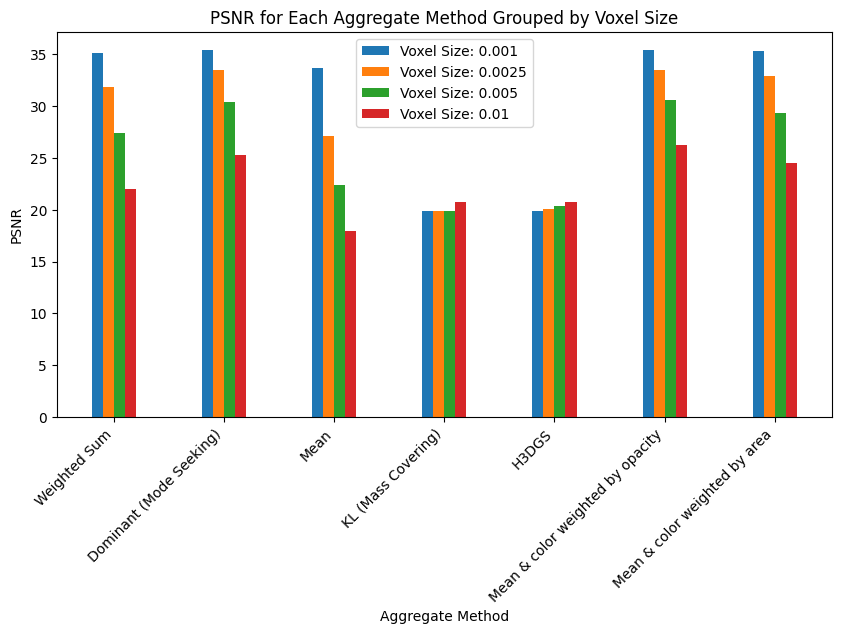

In [42]:
# Create bar plot of PSNR for for each aggregate method grouped by voxel size
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.1

x = np.arange(len(aggregate_methods))

for i, voxel_size in enumerate(allowable_voxel_sizes):
    data = result_dict[voxel_size]
    psnr_values = [data[aggregate_method]["psnr"] for aggregate_method in aggregate_methods]
    ax.bar(x + i * bar_width, psnr_values, bar_width, label=f"Voxel Size: {voxel_size}")

ax.set_xlabel("Aggregate Method")
ax.set_ylabel("PSNR")
ax.set_title("PSNR for Each Aggregate Method Grouped by Voxel Size")
ax.set_xticks(x + bar_width * (len(allowable_voxel_sizes) - 1) / 2)
ax.set_xticklabels(aggregate_methods_rename, rotation=45, ha="right")
ax.legend()

Text(1.5, 36.39, '35.9 PSNR (Highest resolution quality)')

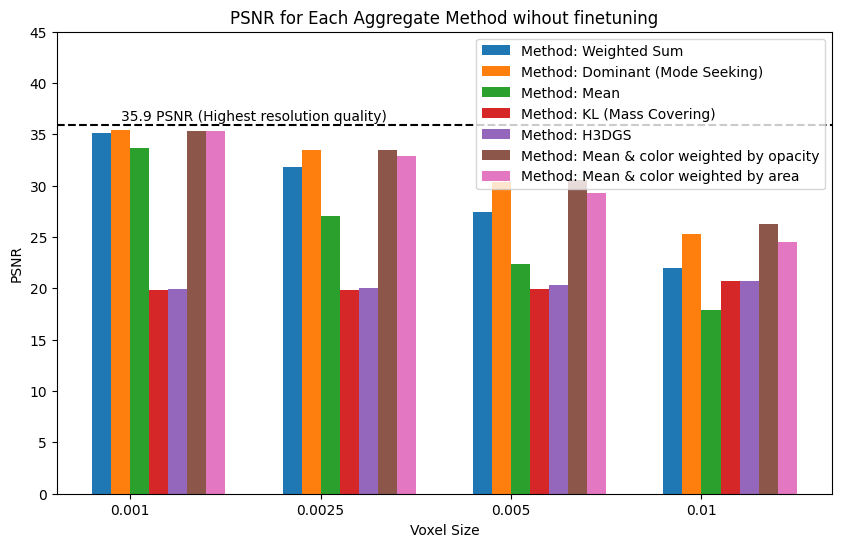

In [55]:
# Create bar plot of PSNR for for each aggregate method grouped by voxel size
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.1

x = np.arange(len(allowable_voxel_sizes))

for i, (aggregate_method, aggregate_method_rename) in enumerate(zip(aggregate_methods, aggregate_methods_rename)):
    # data = result_dict[aggregate_method]
    psnr_values = [result_dict[voxel_size][aggregate_method]["psnr"] for voxel_size in allowable_voxel_sizes]
    ax.bar(x + i * bar_width, psnr_values, bar_width, label=f"Method: {aggregate_method_rename}")

ax.set_xlabel("Voxel Size")
ax.set_ylabel("PSNR")
# ax.set_title("PSNR for Each Aggregate Method Grouped by Voxel Size")
ax.set_xticks(x + bar_width * (len(allowable_voxel_sizes) - 1) / 2)
ax.set_xticklabels(allowable_voxel_sizes)
ax.set_title("PSNR for Each Aggregate Method wihout finetuning")
ax.set_ylim(0, 45)
ax.legend()

# Draw a horizontal line at y=best_psnr
ax.axhline(y=best_psnr, color='black', linestyle='--')

# Add upper bound quality text
ax.text(
    1.5,
    best_psnr + 0.5,
    f"{best_psnr:.1f} PSNR (Highest resolution quality)",
    ha="right",
)

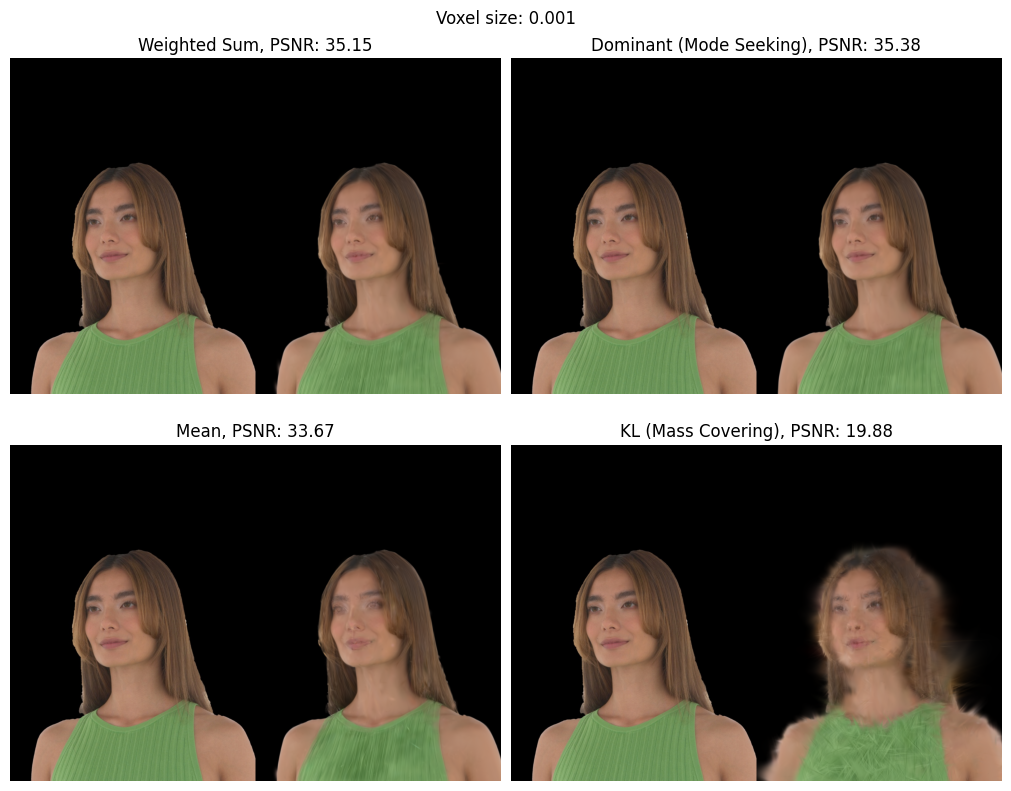

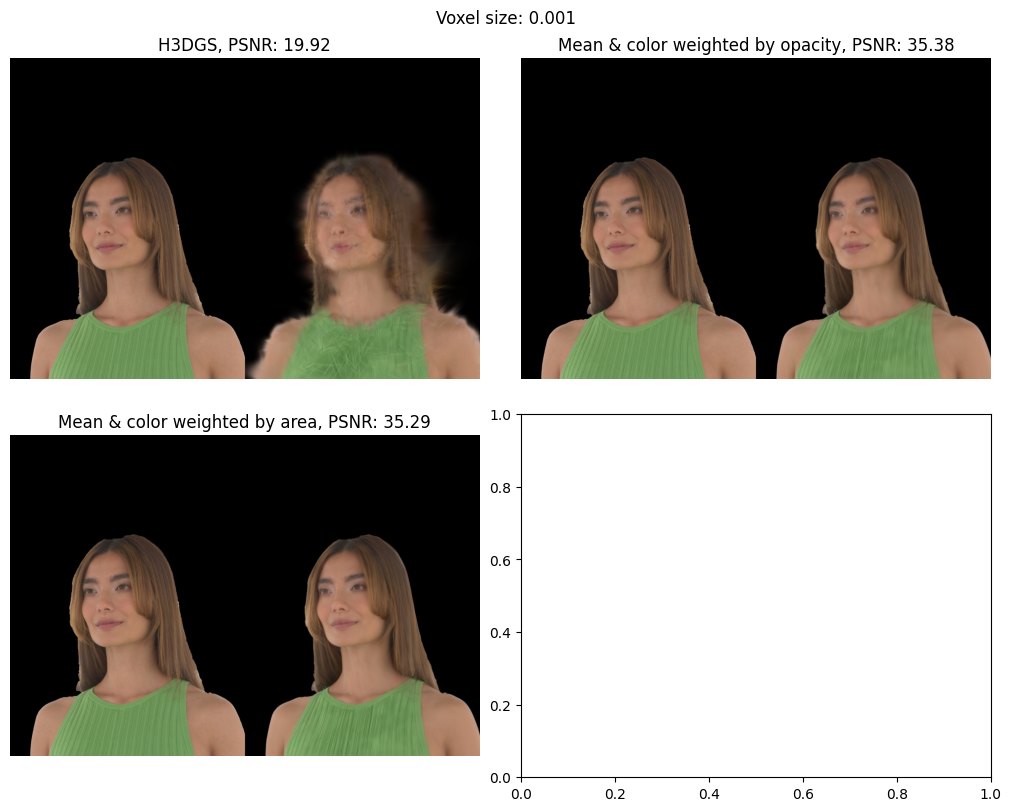

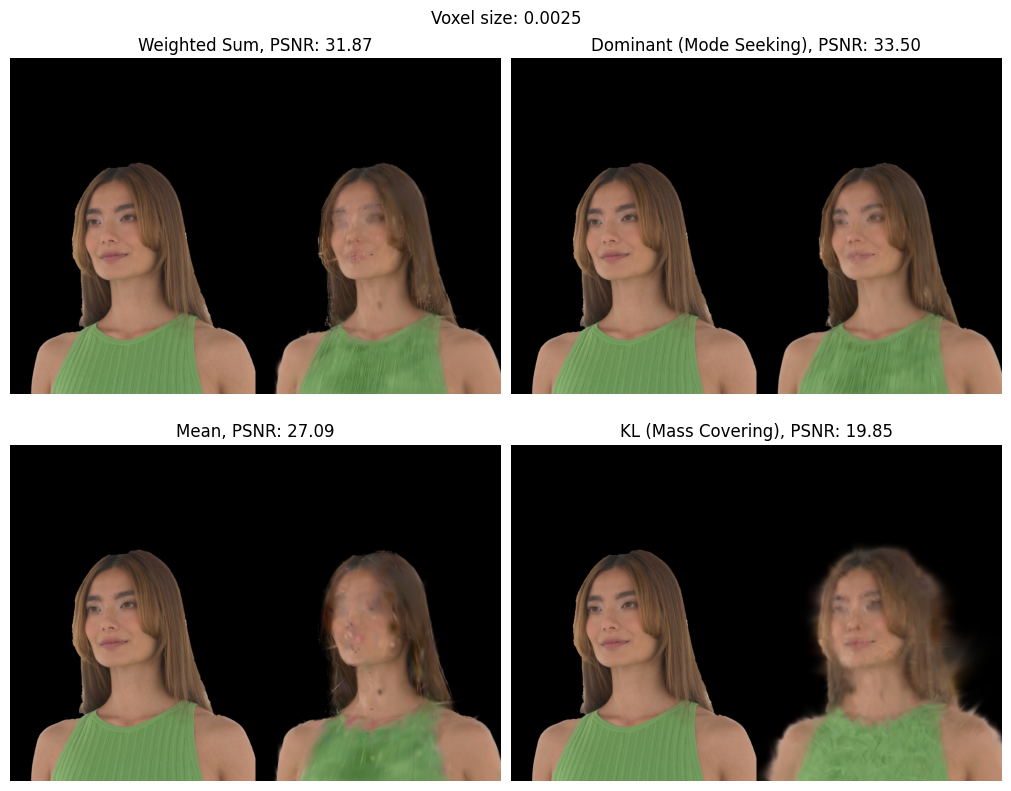

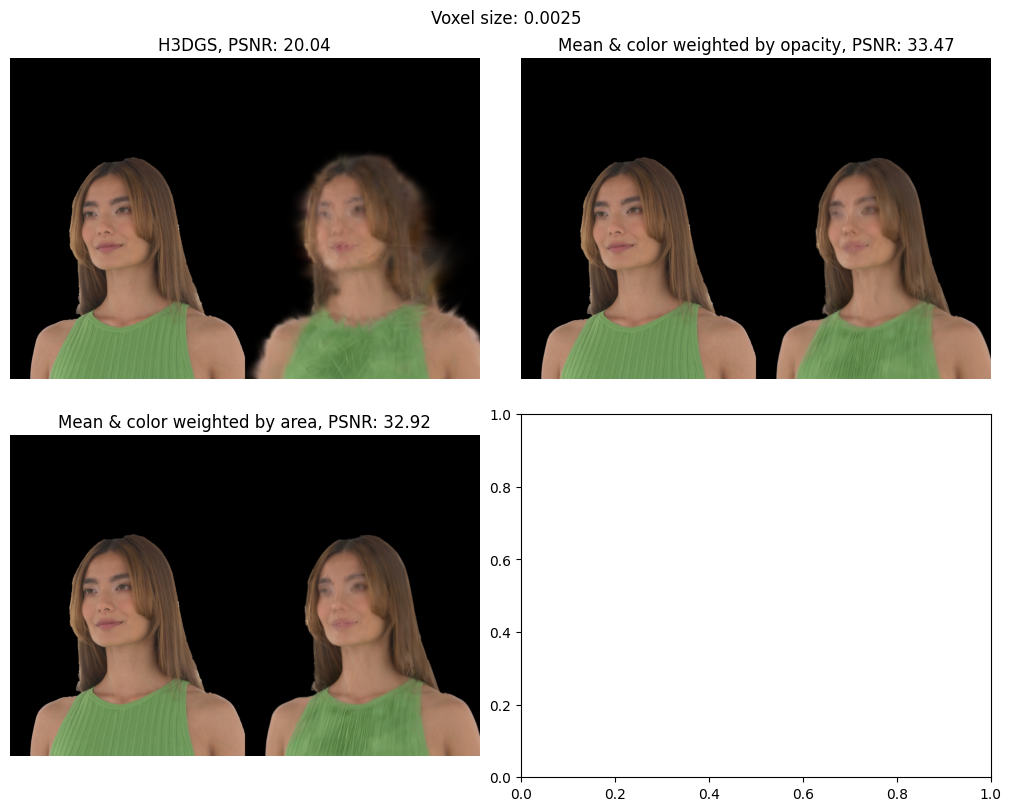

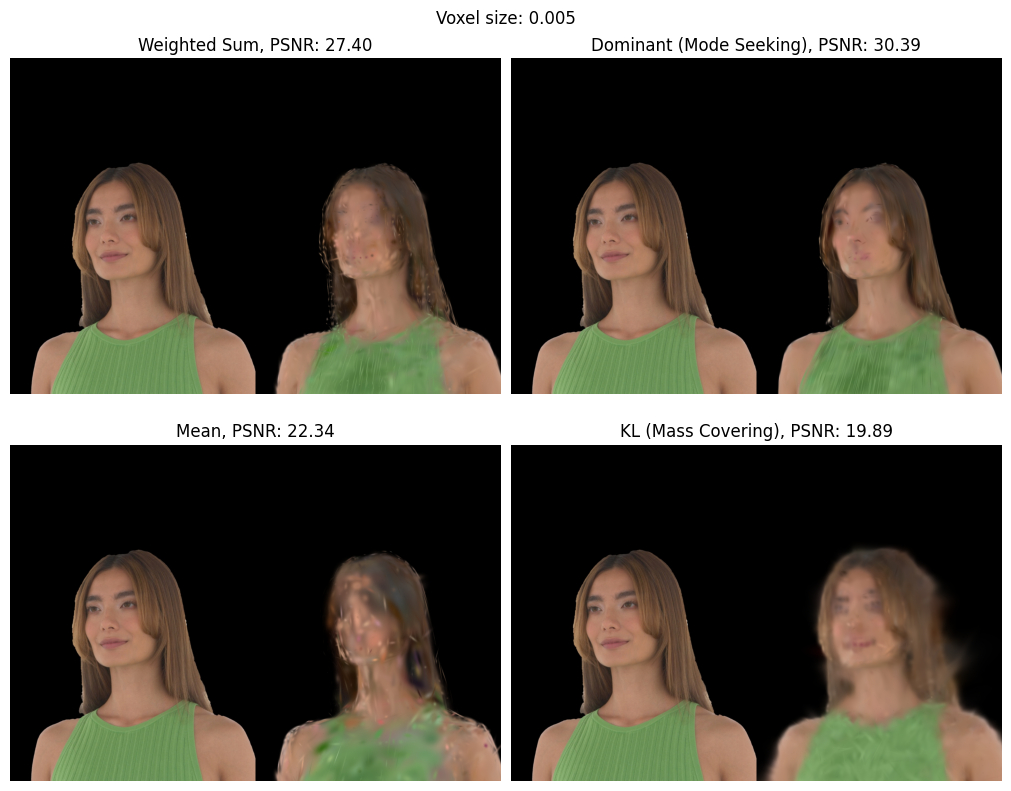

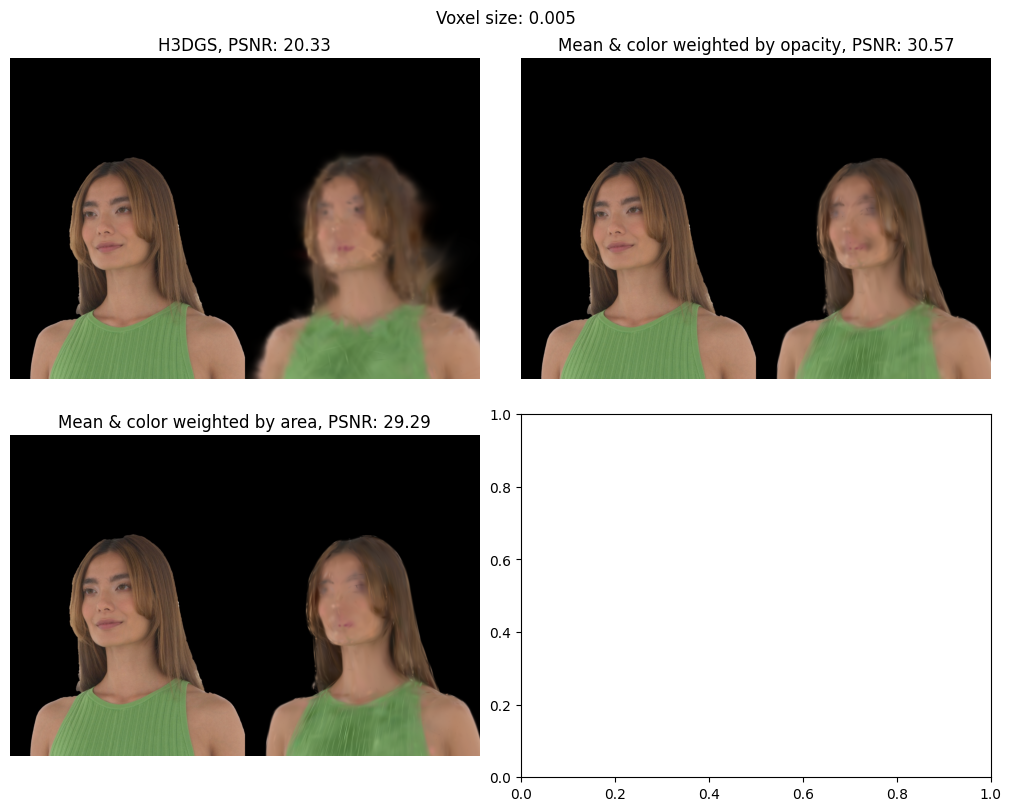

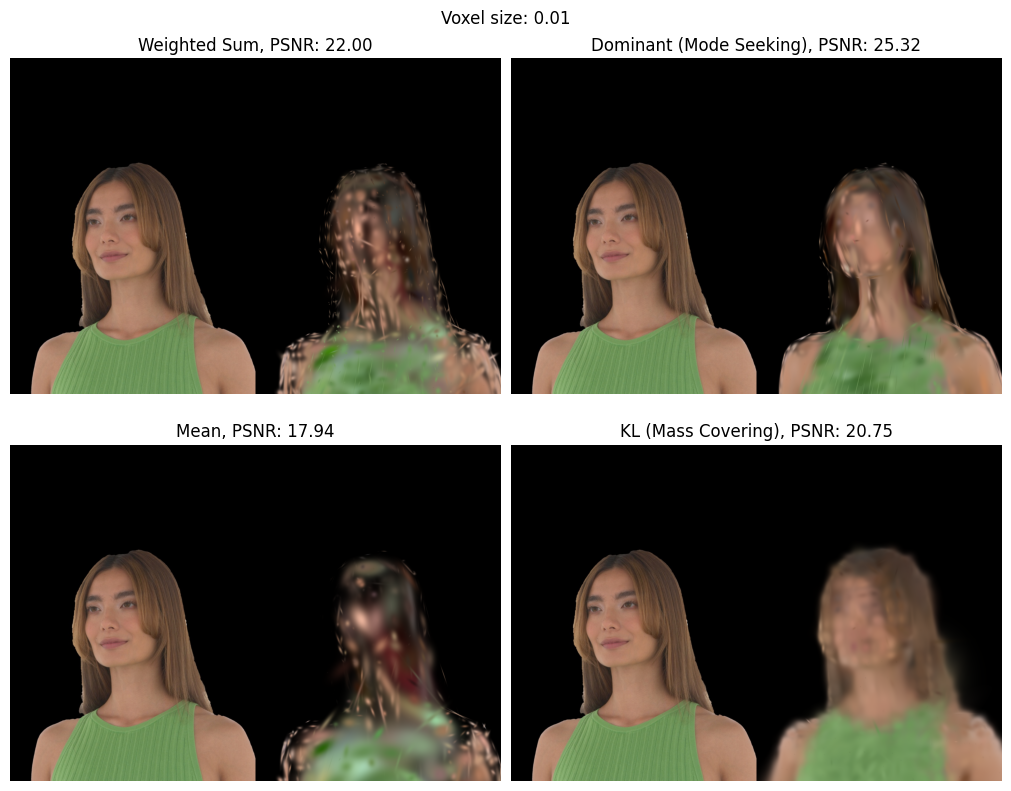

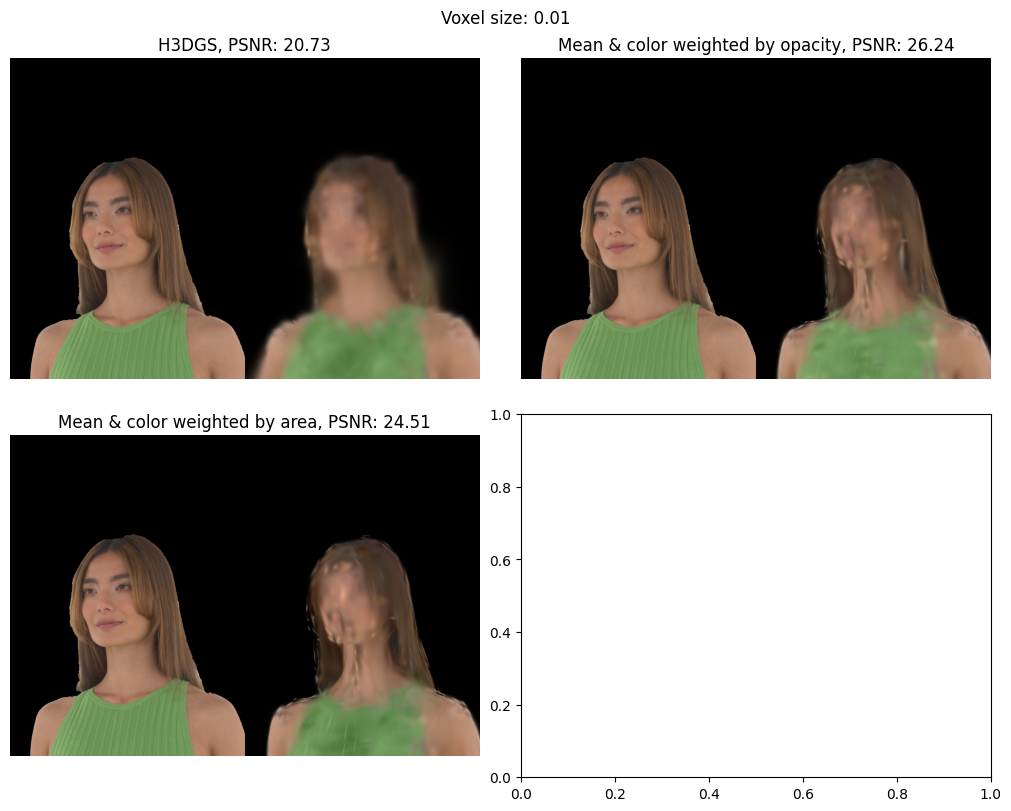

In [54]:
# Create grid of images
exp_names = [
    f"actorshq_l1_0.5_ssim_0.5_alpha_1.0_to_voxel_size_{voxel_size}"
    for voxel_size in allowable_voxel_sizes
]

# Iterate over the grid of images
for voxel_size, exp_name in zip(allowable_voxel_sizes, exp_names):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
    for i, (method, method_name) in enumerate(
        zip(aggregate_methods[:4], aggregate_methods_rename[:4])
    ):
        k = i // 2
        j = i % 2
        ax = axes[k, j]
        result_dir = os.path.join(
            data_dir, exp_name, actor, sequence, f"resolution_{resolution}", f"{frame_id}", f"{method}"
        )

        # Load the image
        image_path = os.path.join(result_dir, "renders", f"val_step0_0015.png")
        image = plt.imread(image_path)

        # Read PSNR, SSIM, LPIPS
        psnr = result_dict[voxel_size][method]["psnr"]
        ssim = result_dict[voxel_size][method]["ssim"]
        lpips = result_dict[voxel_size][method]["lpips"]

        # Display the image
        ax.imshow(image)
        ax.set_title(f"{method_name}, PSNR: {psnr:.2f}")
        ax.axis("off")
    plt.suptitle(f"Voxel size: {voxel_size}")
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
    for i, (method, method_name) in enumerate(
        zip(aggregate_methods[4:7], aggregate_methods_rename[4:7])
    ):
        k = i // 2
        j = i % 2
        ax = axes[k, j]
        result_dir = os.path.join(
            data_dir, exp_name, actor, sequence, f"resolution_{resolution}", f"{frame_id}", f"{method}"
        )

        # Load the image
        image_path = os.path.join(result_dir, "renders", f"val_step0_0015.png")
        image = plt.imread(image_path)

        # Read PSNR, SSIM, LPIPS
        psnr = result_dict[voxel_size][method]["psnr"]
        ssim = result_dict[voxel_size][method]["ssim"]
        lpips = result_dict[voxel_size][method]["lpips"]

        # Display the image
        ax.imshow(image)
        ax.set_title(f"{method_name}, PSNR: {psnr:.2f}")
        ax.axis("off")
    plt.suptitle(f"Voxel size: {voxel_size}")
    plt.show()